Date: 2016-10-06

In [29]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%qtconsole
import os
import sys
import collections
import random
import itertools
import functools
import scipy.fftpack
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import matplotlib.patches as patches
import seaborn as sns
import pandas as pd
import tqdm
import dask
import dask.multiprocessing

sys.path.append('../src/')
import data_filter
import ripple_detection
import spectral

In [22]:
Animal = collections.namedtuple('Animal', {'directory', 'short_name'})
num_days = 8
days = range(1, num_days + 1)
animals = {'HPa': Animal(directory='HPa_direct', short_name='HPa'),
           'HPc': Animal(directory='HPc_direct', short_name='HPc')}

epoch_info = data_filter.make_epochs_dataframe(animals, days)
tetrode_info = data_filter.make_tetrode_dataframe(animals)
epoch_index = (epoch_info
    .loc[(['HPa', 'HPc'], [8]), :]
    .loc[epoch_info.environment == 'wtr1'].index)

cur_tetrode_info = [tetrode_info[key][tetrode_info[key].area.isin(['PFC', 'CA1'])]
                    for key in epoch_index]
cur_tetrode_info

lfp_data = [data_filter.get_LFP_data(epoch.index, animals) for epoch in cur_tetrode_info]
ripple_times = [ripple_detection.get_computed_consensus_ripple_times(index, animals) for index in epoch_index]

### High Frequency Coherence
frequency resolution = number of tapers  / time window duration = 2 / 0.080 = 25 Hz

In [28]:
high_frequency_params = dict(
    baseline_window=(-0.250, 0),
    window_of_interest=(-0.400, .400),
    sampling_frequency=1500,
    time_window_duration=0.080,
    time_window_step=0.080,
    desired_frequencies=[100, 300],
    time_halfbandwidth_product=2
)
    
high_frequency_coherence = [
    [spectral.difference_from_baseline_coherence([lfp1, lfp2], epoch_ripple_times, **high_frequency_params)
     for lfp1, lfp2 in itertools.combinations(epoch_lfps, 2)]
    for epoch_lfps, epoch_ripple_times in zip(lfp_data, ripple_times)]

np.save('high_frequency_coherence', high_frequency_coherence)

In [201]:
def combine_tetrode_pair(tetrode1, tetrode2):
    return pd.concat([tetrode1, tetrode2], axis=0, keys=['tetrode1', 'tetrode2'])


def epoch_pairs(epoch_tetrode_info):
    return pd.concat([combine_tetrode_pair(epoch_tetrode_info.loc[ind1, :], epoch_tetrode_info.loc[ind2, :])
                      for ind1, ind2 in itertools.combinations(epoch_tetrode_info.index, 2)], axis=1).transpose()


tetrode_pair_info = [epoch_pairs(epoch_tetrode_info)
                     for epoch_tetrode_info in cur_tetrode_info]
tetrode_pair_info[0]

tetrode1                                   tetrode2                         \
       area depth descrip numcells tetrode_id     area depth descrip numcells   
0       CA1   113  riptet       12     HPa821      CA1   121     NaN        0   
1       CA1   113  riptet       12     HPa821      CA1    90  CA1Ref        0   
2       CA1   113  riptet       12     HPa821      CA1   116  riptet       15   
3       CA1   113  riptet       12     HPa821      CA1   116  riptet        0   
4       CA1   113  riptet       12     HPa821      CA1   110  riptet        0   
5       CA1   113  riptet       12     HPa821      CA1   114  riptet        0   
6       CA1   113  riptet       12     HPa821      PFC    93     NaN        0   
7       CA1   113  riptet       12     HPa821      PFC    90     NaN        0   
8       CA1   113  riptet       12     HPa821      PFC    90     NaN        6   
9       CA1   113  riptet       12     HPa821      PFC    90     NaN        0   
10      CA1   113  riptet       12     HPa821      PFC   130     NaN        0   
11      CA1   113  riptet       12     HPa821      PFC   109     NaN        0   
12      CA1   121     NaN        0     HPa822      CA1    90  CA1Ref        0   
13      CA1   121     NaN        0     HPa822      CA1   116  riptet       15   
14      CA1   121     NaN        0     HPa822      CA1   116  riptet        0   
15      CA1   121     NaN        0     HPa822      CA1   110  riptet        0   
16      CA1   121     NaN        0     HPa822      CA1   114  riptet        0   
17      CA1   121     NaN        0     HPa822      PFC    93     NaN        0   
18      CA1   121     NaN        0     HPa822      PFC    90     NaN        0   
19      CA1   121     NaN        0     HPa822      PFC    90     NaN        6   
20      CA1   121     NaN        0     HPa822      PFC    90     NaN        0   
21      CA1   121     NaN        0     HPa822      PFC   130     NaN        0   
22      CA1   121     NaN        0     HPa822      PFC   109     NaN        0   
23      CA1    90  CA1Ref        0     HPa823      CA1   116  riptet       15   
24      CA1    90  CA1Ref        0     HPa823      CA1   116  riptet        0   
25      CA1    90  CA1Ref        0     HPa823      CA1   110  riptet        0   
26      CA1    90  CA1Ref        0     HPa823      CA1   114  riptet        0   
27      CA1    90  CA1Ref        0     HPa823      PFC    93     NaN        0   
28      CA1    90  CA1Ref        0     HPa823      PFC    90     NaN        0   
29      CA1    90  CA1Ref        0     HPa823      PFC    90     NaN        6   
..      ...   ...     ...      ...        ...      ...   ...     ...      ...   
48      CA1   116  riptet        0     HPa825      PFC   130     NaN        0   
49      CA1   116  riptet        0     HPa825      PFC   109     NaN        0   
50      CA1   110  riptet        0     HPa826      CA1   114  riptet        0   
51      CA1   110  riptet        0     HPa826      PFC    93     NaN        0   
52      CA1   110  riptet        0     HPa826      PFC    90     NaN        0   
53      CA1   110  riptet        0     HPa826      PFC    90     NaN        6   
54      CA1   110  riptet        0     HPa826      PFC    90     NaN        0   
55      CA1   110  riptet        0     HPa826      PFC   130     NaN        0   
56      CA1   110  riptet        0     HPa826      PFC   109     NaN        0   
57      CA1   114  riptet        0     HPa827      PFC    93     NaN        0   
58      CA1   114  riptet        0     HPa827      PFC    90     NaN        0   
59      CA1   114  riptet        0     HPa827      PFC    90     NaN        6   
60      CA1   114  riptet        0     HPa827      PFC    90     NaN        0   
61      CA1   114  riptet        0     HPa827      PFC   130     NaN        0   
62      CA1   114  riptet        0     HPa827      PFC   109     NaN        0   
63      PFC    93     NaN        0    HPa8215      PFC    90     NaN        0   
64      PFC    93     NaN        0

/Users/edeno/anaconda3/envs/Jadhav-2016-Data-Analysis/lib/python3.5/site-packages/ipykernel/__main__.py:17: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


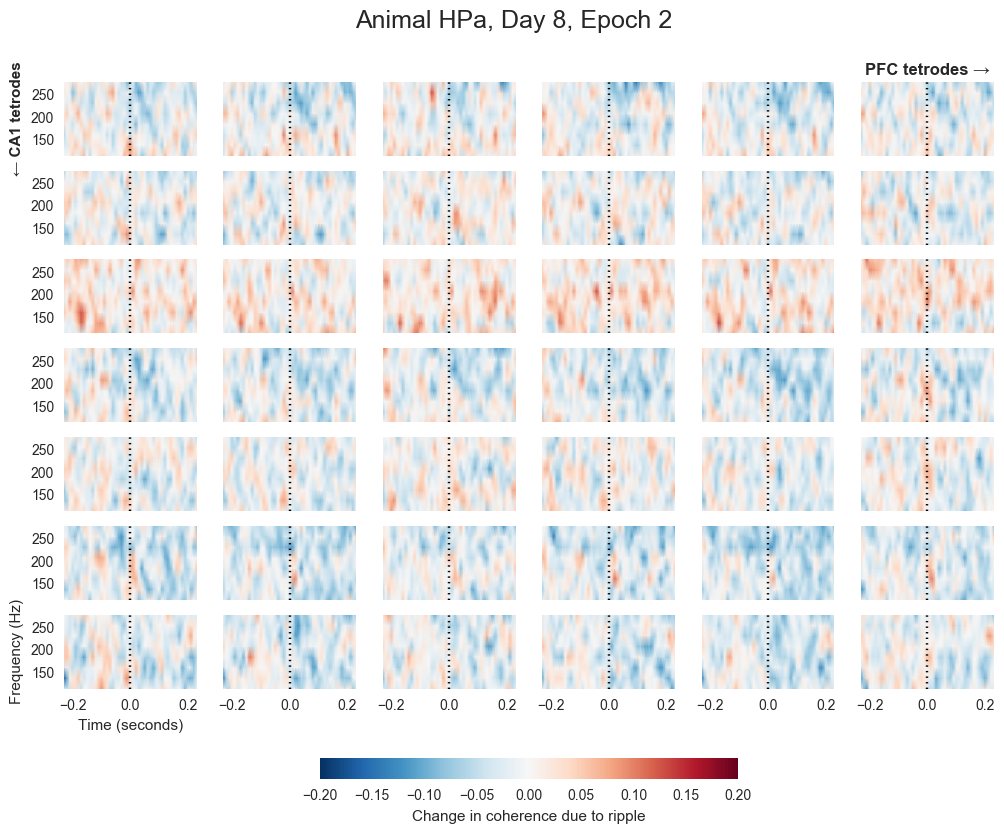

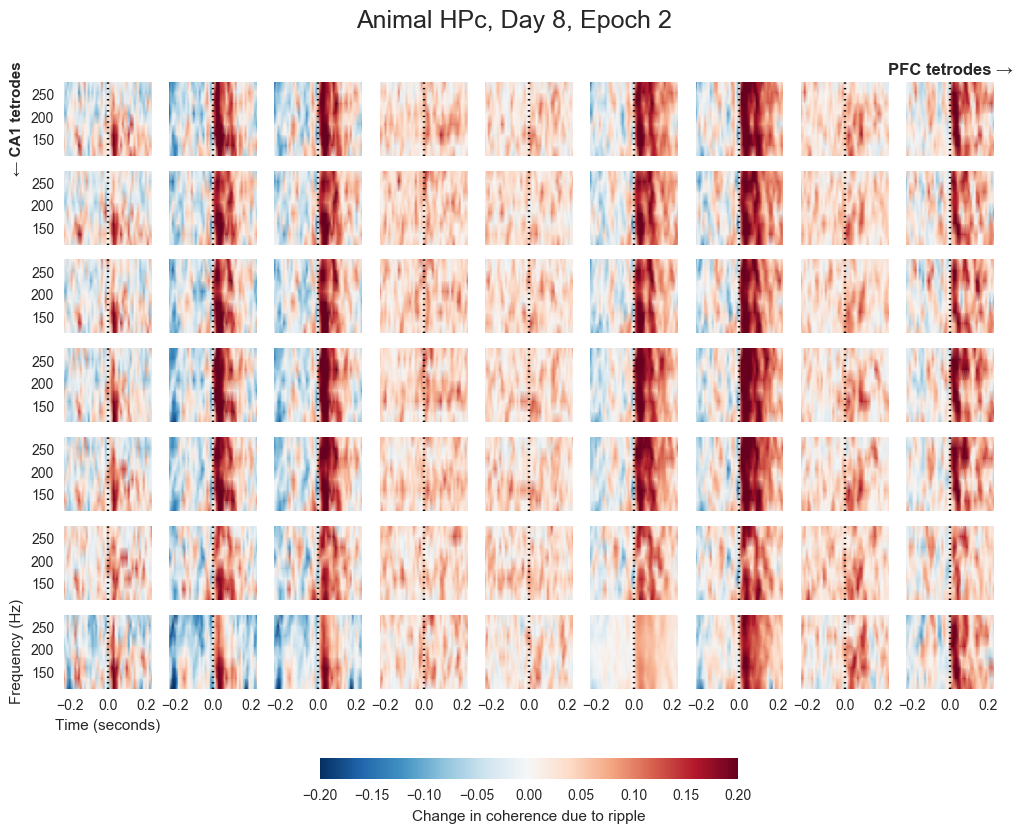

In [359]:
def get_pair_index(df, tetrode1_id, tetrode2_id):
    return df[(df.loc[:, 'tetrode1'].tetrode_id == tetrode1_id) &
           (df.loc[:, 'tetrode2'].tetrode_id == tetrode2_id)].index.values

for epoch_ind, epoch in enumerate(epoch_index):
    CA1_tetrodes = cur_tetrode_info[epoch_ind].query('area == "CA1"')
    PFC_tetrodes = cur_tetrode_info[epoch_ind].query('area == "PFC"')

    num_rows = len(CA1_tetrodes)
    num_cols = len(PFC_tetrodes)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12,9), sharex=True, sharey=True)

    for row_ind, CA1_tetrode_id in enumerate(CA1_tetrodes.tetrode_id):
        for col_ind, PFC_tetrode_id in enumerate(PFC_tetrodes.tetrode_id):
            pair_ind = get_pair_index(tetrode_pair_info[epoch_ind], CA1_tetrode_id, PFC_tetrode_id)
            mesh = spectral.plot_coherogram(high_frequency_coherence[epoch_ind][pair_ind],
                                     vmin=-0.2,
                                     vmax=0.2,
                                     cmap='RdBu_r',
                                     axis_handle=axes[row_ind, col_ind])
            axes[row_ind, col_ind].axvline(0, color='black', linestyle=':')
            axes[row_ind, col_ind].set_xticks([-0.2, 0, 0.2])

    axes[-1, 0].set_xlabel('Time (seconds)')
    axes[-1, 0].set_ylabel('Frequency (Hz)')
    axes[0, -1].set_title('PFC tetrodes →', fontweight='bold')
    axes[0, 0].set_ylabel('← CA1 tetrodes', fontweight='bold')
    plt.colorbar(mesh, ax=axes.ravel().tolist(), orientation='horizontal',
                 fraction=0.03, pad=0.1, label='Change in coherence due to ripple')
    plt.suptitle('Animal {0}, Day {1}, Epoch {2}'.format(*epoch), fontsize=18)

### Gamma Frequencies

## Ripple Times Spectrum

In [ ]:
params = dict(
    sampling_frequency=1500,
    time_halfbandwidth_product=12,
)

def convert_ripple_times_to_dataframe(ripple_times, index):
    return (pd.DataFrame({'time': np.array(ripple_times)[:, 0], 'is_ripple': 1})
              .set_index('time')
              .reindex(index=index.values,
                       tolerance=1E-4,
                       method='nearest',
                       fill_value=0))

ripple_psd = [spectral.multitaper_power_spectral_density(
                convert_ripple_times_to_dataframe(epoch_ripple_times, epoch_lfps[0].index), **params)
              for epoch_lfps, epoch_ripple_times
              in zip(lfp_data, ripple_times)]

print(ripple_psd)

In [ ]:
ripple_psd[0].plot()
ripple_psd[1].plot()